In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

mkdir: /Users/brigt/.kaggle: File exists
cp: kaggle.json: No such file or directory
chmod: /Users/brigt/.kaggle/kaggle.json: No such file or directory


In [4]:
!kaggle datasets download -d shilongzhuang/telecom-customer-churn-by-maven-analytics

Dataset URL: https://www.kaggle.com/datasets/shilongzhuang/telecom-customer-churn-by-maven-analytics
License(s): other
100%|█████████████████████████████████████████| 434k/434k [00:00<00:00, 870kB/s]
100%|█████████████████████████████████████████| 434k/434k [00:00<00:00, 868kB/s]


In [3]:
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 402.9 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Created wheel for kaggle: filename=kaggle-1.6.14-py3-none-any.whl size=105119 sha256=3725b74c5309ea1fc5c9baefd4f845964bca61434cd8ec17a43123659ed59d45
  Stored in directory: /Users/brigt/Library/Caches/pip/wheels/ec/d9/04/93be57edf3835182a8e76d8ff87f7e77a0113f473ba3721ee0
Successfully built kaggle


In [7]:
!unzip telecom-customer-churn-by-maven-analytics.zip

Archive:  telecom-customer-churn-by-maven-analytics.zip
  inflating: telecom_customer_churn.csv  
  inflating: telecom_data_dictionary.csv  
  inflating: telecom_zipcode_population.csv  


In [8]:
!pip install ml_insights -q

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ml_insights as mli
%matplotlib inline
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, f1_score
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

In [3]:
!pip install lightgbm

In [5]:
data = pd.read_csv('telecom_customer_churn.csv')
data.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [6]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

In [7]:
data = data.iloc[:, [1, 2, 3, 4, 9, 10, 11, 12, 15, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]


In [8]:
data = data[data['Customer Status'] != 'Joined'].reset_index(drop=True)


In [9]:
data['Customer Status'].value_counts()


Customer Status
Stayed     4720
Churned    1869
Name: count, dtype: int64

In [10]:
data['Customer Status'] = data['Customer Status'].apply(lambda x: 1 if x == 'Churned' else 0)


In [11]:
data['Customer Status'].value_counts()


Customer Status
0    4720
1    1869
Name: count, dtype: int64

In [12]:
data.head()


,Gender,Age,Married,Number of Dependents,Number of Referrals,Tenure in Months,Offer,Phone Service,Internet Service,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status
0,Female,37,Yes,0,2,9,NaN,Yes,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,0
1,Male,46,No,0,0,9,NaN,Yes,Yes,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,0
2,Male,50,No,0,0,4,Offer E,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,1
3,Male,78,Yes,0,1,13,Offer D,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,1
4,Female,75,Yes,0,3,3,NaN,Yes,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,1


In [13]:
# Extract categoricals and their indices
cat_features = data.select_dtypes(exclude=np.number).columns.to_list()
cat_idx = [data.columns.get_loc(col) for col in cat_features]

# Convert cat_features to pd.Categorical dtype
for col in cat_features:
    data[col] = pd.Categorical(data[col])

In [14]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6589 entries, 0 to 6588
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Gender                       6589 non-null   category
 1   Age                          6589 non-null   int64   
 2   Married                      6589 non-null   category
 3   Number of Dependents         6589 non-null   int64   
 4   Number of Referrals          6589 non-null   int64   
 5   Tenure in Months             6589 non-null   int64   
 6   Offer                        2991 non-null   category
 7   Phone Service                6589 non-null   category
 8   Internet Service             6589 non-null   category
 9   Contract                     6589 non-null   category
 10  Paperless Billing            6589 non-null   category
 11  Payment Method               6589 non-null   category
 12  Monthly Charge               6589 non-null   float64 
 13  Tot

In [15]:
train_perc = 0.4
val_perc = 0.3
test_perc = 0.3
rs = 1234

X_train_val, X_test, y_train_val, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1], test_size=test_perc,
                                                            random_state=rs, stratify=data.iloc[:, -1])

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_perc, random_state=rs,
                                                  stratify=y_train_val)

In [16]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3228, 18), (3228,), (1384, 18), (1384,), (1977, 18), (1977,))

In [17]:
y_train.value_counts()


Customer Status
0    2313
1     915
Name: count, dtype: int64

In [18]:
y_test.value_counts()

Customer Status
0    1416
1     561
Name: count, dtype: int64

In [19]:
%%time

lgbm_clf = lgbm.LGBMClassifier(
    objective="binary",
    random_state=rs,
    n_estimators=10,
    boosting="gbdt",  # default histogram binning of LGBM
    class_weight="balanced",
)

lgbm_clf.fit(
    X_train,
    y_train,
    categorical_feature=cat_idx

)

preds_uncalibrated_val = lgbm_clf.predict_proba(X_val)[:, 1]
print(f"LightGBM logloss on the evaluation set: {log_loss(y_val, preds_uncalibrated_val):.5f}")
print(f"LightGBM ROC-AUC on the evaluation set: {roc_auc_score(y_val, preds_uncalibrated_val):.5f}")
print(f"LightGBM F1 on the evaluation set: {f1_score(y_val, lgbm_clf.predict(X_val)):.5f}")

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 915, number of negative: 2313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1307
[LightGBM] [Info] Number of data points in the train set: 3228, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
LightGBM logloss on the evaluation set: 0.

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
LightGBM logloss on the test set: 0.41464
LightGBM ROC-AUC on the test set: 0.92840
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
LightGBM F1 on the test set: 0.75545



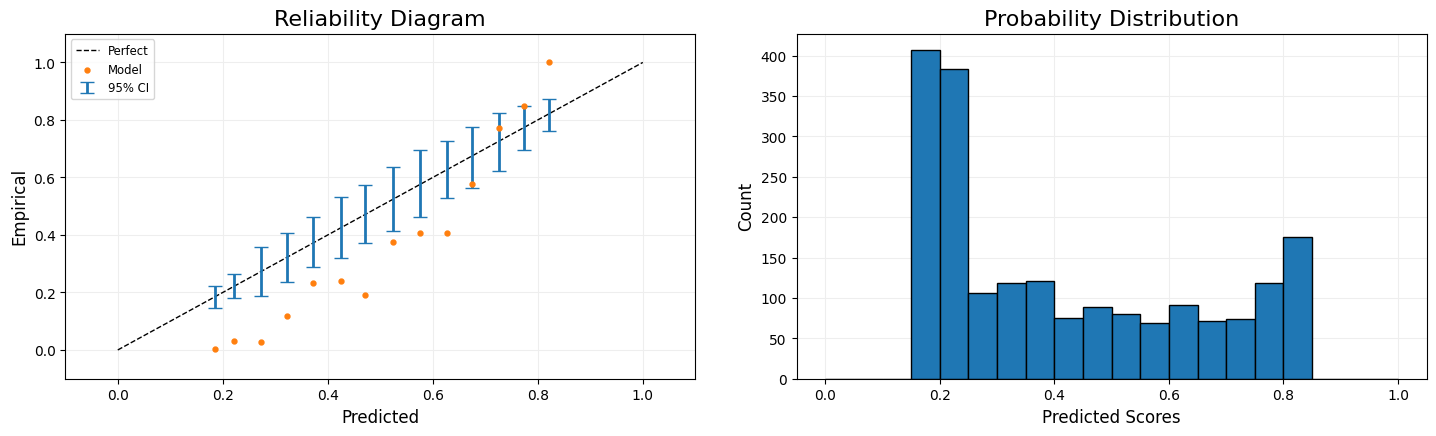

In [20]:
preds_uncalibrated_test = lgbm_clf.predict_proba(X_test)[:, 1]
print(f"LightGBM logloss on the test set: {log_loss(y_test, preds_uncalibrated_test):.5f}")
print(f"LightGBM ROC-AUC on the test set: {roc_auc_score(y_test, preds_uncalibrated_test):.5f}")
print(f"LightGBM F1 on the test set: {f1_score(y_test, lgbm_clf.predict(X_test)):.5f}")
print()
plt.figure(figsize=(15, 5))
rd = mli.plot_reliability_diagram(y_test, preds_uncalibrated_test, show_histogram=True)

In [30]:
y_test

5150    1
4150    0
860     1
5342    0
1572    1
       ..
5970    0
2034    0
1136    0
2657    1
3505    0
Name: Customer Status, Length: 1977, dtype: int64

In [31]:
preds_uncalibrated_test

array([0.62853964, 0.57947347, 0.55200853, ..., 0.58484257, 0.51911898,
       0.18215981])

In [33]:
print(y_test)

5150    1
4150    0
860     1
5342    0
1572    1
       ..
5970    0
2034    0
1136    0
2657    1
3505    0
Name: Customer Status, Length: 1977, dtype: int64


In [34]:
type(y_test)

pandas.core.series.Series

In [35]:
preds_uncalibrated_test

array([0.62853964, 0.57947347, 0.55200853, ..., 0.58484257, 0.51911898,
       0.18215981])

In [36]:
preds_uncalibrated_test.shape

(1977,)

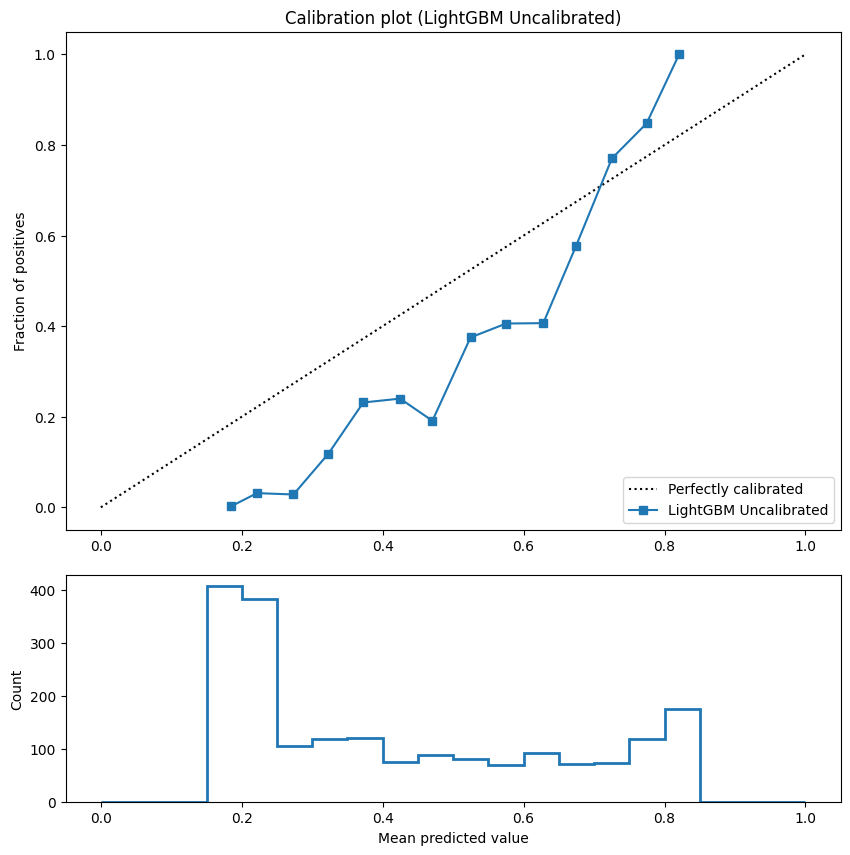

In [21]:
from sklearn.calibration import calibration_curve


def plot_calibration_curve(name, fig_index, probs):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    frac_of_pos, mean_pred_value = calibration_curve(y_test, probs, n_bins=20)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')

    ax2.hist(probs, range=(0, 1), bins=20, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")


plot_calibration_curve("LightGBM Uncalibrated", 1, preds_uncalibrated_test)

In [22]:
# Fit Platt scaling (logistic calibration)
lr = LogisticRegression(C=99999999999, solver='lbfgs')
lr.fit(preds_uncalibrated_val.reshape(-1, 1), y_val)

LogisticRegression(C=99999999999)

LightGBM logloss on the test set: 0.30868
LightGBM ROC-AUC on the test set: 0.92840



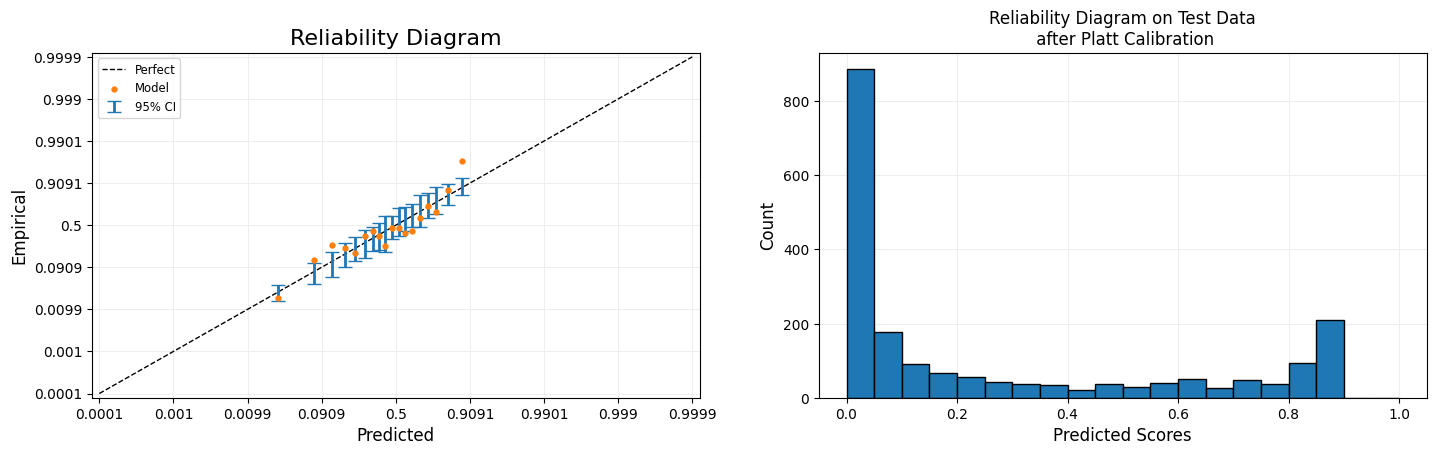

In [23]:
testset_platt_probs = lr.predict_proba(preds_uncalibrated_test.reshape(-1, 1))[:, 1]
print(f"LightGBM logloss on the test set: {log_loss(y_test, testset_platt_probs):.5f}")
print(f"LightGBM ROC-AUC on the test set: {roc_auc_score(y_test, testset_platt_probs):.5f}")
print()
plt.figure(figsize=(15, 5))
mli.plot_reliability_diagram(y_test, testset_platt_probs, show_histogram=True, scaling='logit');
plt.title('Reliability Diagram on Test Data\n after Platt Calibration');